In [1]:
import torch
import torchvision
import construct
import prep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_dir = 'data/raman_images'
labels_file = 'data/labels.csv'

DATA = prep.prep_data(pd.read_csv(labels_file), image_dir)

transforms = torchvision.transforms.Compose([
                            torchvision.transforms.ToPILImage(),
                            torchvision.transforms.RandomRotation((-180,180)),
                            torchvision.transforms.CenterCrop((325)),
                            torchvision.transforms.ToTensor()
                                      ])

/Users/Will/GradSchool/CHEME/Project/FmPM/fmpm/will/prep.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identification[i] = False
/Users/Will/GradSchool/CHEME/Project/FmPM/fmpm/will/prep.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identification[i] = True


In [3]:
data = prep.tenX_dataset(DATA, 'data/raman_images', transform=transforms)
criterion = torch.nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test, train = torch.utils.data.random_split(data, [int(.15*len(data)), len(data)-int(.15*len(data))])
BATCH_SIZE = 32
epochs = 150

In [4]:
class myModel(torch.nn.Module):
    def __init__(self):
        """
        Initializes CNN. Here we just define layer shapes that we call in the forward func
        """
        super().__init__()

        self.conv1 = torch.nn.Conv2d(in_channels = 3, 
                               out_channels = 6, 
                               kernel_size = 5,
                                    bias = False)
                
        #Convultion layer 2. See above
        self.conv2 = torch.nn.Conv2d(in_channels = 6, 
                               out_channels = 12, 
                               kernel_size = 5,
                                    bias = False)
        
        self.fc_1 = torch.nn.Linear(39 * 39 * 12, 256)
        self.fc_2 = torch.nn.Linear(256, 2)
        self.drop = torch.nn.Dropout(p=.2)
        self.batch1 = torch.nn.BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.batch2 = torch.nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            
    def forward(self, x):
        """
        Function that performs all the neural network forward calculation i.e.
        takes image data from the input of the neural network to the output
        """
        
        x = self.conv1(x)
        x = self.batch1(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size = 2)
        x = torch.nn.functional.leaky_relu(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = torch.nn.functional.max_pool2d(x, kernel_size = 4)
        x = torch.nn.functional.leaky_relu(x)
        x = x.view(x.shape[0], -1)  
        x = self.fc_1(x) 
        x = torch.nn.functional.leaky_relu(x)
        x = self.drop(x)
        x = self.fc_2(x) 
        return x

model = myModel()

In [5]:
model, loss, acc, test_acc = construct.train_test(200, 32, train, test, torch.nn.CrossEntropyLoss(), 'Adam', model)

EPOCH: 0, acc: 0.5933975577354431, loss: 4.665028789213726
tensor([[  1.3643,  -0.9373],
        [ -1.5760,   3.2046],
        [ -0.1302,   2.7441],
        [ -1.2412,   3.8527],
        [ 11.3554,  -9.2358],
        [ -1.3835,   3.9730],
        [  0.9042,   0.1316],
        [ -3.0134,   4.7125],
        [  3.2402,  -2.2699],
        [ 10.8481, -11.3199],
        [  6.0952,  -7.2788],
        [  8.2869, -12.0884],
        [  1.0921,  -1.5068],
        [ 32.1625, -50.5054],
        [ -1.8648,   2.9519],
        [ -4.5026,   5.8841],
        [  4.4741,  -5.6614],
        [ -0.1131,   1.2585],
        [  5.6427,  -5.9664]], grad_fn=<AddmmBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]])
EPOCH: 1, acc: 0.6058505645820073, loss:

EPOCH: 35, acc: 0.7312030068465641, loss: 0.5648937055042812
tensor([[ 2.2995e-01, -5.2336e-01],
        [ 6.4818e-01, -1.3062e+00],
        [ 5.1377e-01, -1.0527e+00],
        [ 2.1578e-01, -4.9222e-01],
        [ 4.2822e-01, -8.6613e-01],
        [ 1.8394e-01, -4.2688e-01],
        [ 6.0494e-01, -1.2614e+00],
        [-1.5197e-01,  2.9363e-04],
        [-9.3361e-02,  1.9982e-01],
        [-2.7959e-02,  5.1702e-02],
        [ 5.1813e-01, -1.0632e+00],
        [ 4.3719e-01, -9.0772e-01],
        [ 3.5261e-01, -7.4470e-01],
        [ 4.1425e-01, -8.7399e-01],
        [ 4.9233e-01, -1.0196e+00],
        [ 5.1290e-01, -1.0516e+00],
        [ 4.8482e-01, -1.0106e+00],
        [ 5.1150e-01, -1.0489e+00],
        [ 5.0427e-01, -1.0413e+00]], grad_fn=<AddmmBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
     

EPOCH: 68, acc: 0.7348449230194092, loss: 0.5598886694226947
EPOCH: 69, acc: 0.7498825192451477, loss: 0.5452562485422406
EPOCH: 70, acc: 0.753641916172845, loss: 0.5321425369807652
tensor([[-0.3341, -0.9484],
        [ 0.5407, -0.7235],
        [ 0.1716, -0.6413],
        [-0.4015, -0.0088],
        [-0.6919,  0.4622],
        [ 0.1125, -0.4060],
        [-0.5288,  0.6109],
        [-0.1926, -1.4715],
        [ 0.3027, -0.7826],
        [ 0.3007, -0.7744],
        [ 0.1814, -0.5983],
        [ 0.1144, -0.4658],
        [ 0.1171, -0.9939],
        [-0.0924, -0.9679],
        [ 0.2921, -0.7568],
        [-0.2138, -1.5705],
        [ 0.2500, -0.6953],
        [ 0.2621, -0.7215],
        [-0.3886, -0.2187]], grad_fn=<AddmmBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
    

EPOCH: 103, acc: 0.7811325192451477, loss: 0.49842710154397146
EPOCH: 104, acc: 0.7729088366031647, loss: 0.5107543894222805
EPOCH: 105, acc: 0.7663298887865884, loss: 0.5188414752483368
tensor([[-3.0149e-01, -1.1159e+00],
        [-1.4490e+00,  1.7726e+00],
        [ 2.0386e-01, -8.3074e-01],
        [-2.2720e+00,  1.4169e+01],
        [ 3.6448e-01, -1.0885e+00],
        [ 3.0103e-01, -9.0143e-01],
        [ 3.0239e-01, -9.0529e-01],
        [ 2.9308e-01, -9.0442e-01],
        [-3.9194e-01, -1.1163e+00],
        [-6.4237e-01,  6.7659e-02],
        [ 1.3512e+00, -2.4640e-02],
        [ 3.0404e-01, -9.0530e-01],
        [ 3.7628e-03, -4.2904e-01],
        [ 3.0507e-01, -9.1428e-01],
        [ 5.5951e-01, -1.6497e+00],
        [-3.2697e-01, -3.9010e-01],
        [-1.1112e-01, -1.0416e+00],
        [ 3.0291e-01, -9.0428e-01],
        [ 9.7873e-01,  1.5158e-01]], grad_fn=<AddmmBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
       

EPOCH: 136, acc: 0.7737312018871307, loss: 0.5082517372710365
EPOCH: 137, acc: 0.7899436099188668, loss: 0.5007364089999881
EPOCH: 138, acc: 0.745418233530862, loss: 0.5385058309350695
EPOCH: 139, acc: 0.756461467061724, loss: 0.5448124217135566
EPOCH: 140, acc: 0.7617481223174504, loss: 0.5136771649122238
tensor([[ 0.1468, -1.0721],
        [-0.5453, -0.1102],
        [ 0.1931, -1.0811],
        [-0.5252, -1.1571],
        [ 0.2265, -1.0981],
        [-1.5031, -0.1055],
        [-0.5860, -1.3996],
        [-2.0148,  1.5172],
        [-0.5846, -2.1343],
        [-1.2586, -0.1601],
        [ 0.0886, -0.5363],
        [-0.4354, -1.8545],
        [-1.2689,  2.2763],
        [ 0.1255, -0.9290],
        [-0.4318, -0.8843],
        [-0.1268, -1.8720],
        [ 0.3111, -1.3405],
        [-1.0862,  0.2369],
        [-0.4775, -1.9856]], grad_fn=<AddmmBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
      

EPOCH: 171, acc: 0.7609257527760097, loss: 0.5092032189880099
EPOCH: 172, acc: 0.7616306373051235, loss: 0.5068373680114746
EPOCH: 173, acc: 0.7855968049594334, loss: 0.49822366663387846
EPOCH: 174, acc: 0.7796052651745933, loss: 0.486418611236981
EPOCH: 175, acc: 0.7929981223174504, loss: 0.49258696607181
tensor([[-0.5698, -1.4623],
        [-0.2107, -0.9522],
        [-2.2792,  2.1005],
        [ 0.0877, -0.6967],
        [-0.0168, -0.6796],
        [ 0.1577, -0.8220],
        [-0.9806,  0.9300],
        [ 0.1571, -0.8297],
        [ 0.4427, -0.9445],
        [-0.4724, -1.3151],
        [-0.4295, -1.2664],
        [ 0.1503, -0.8307],
        [ 0.0951, -0.7694],
        [-1.9101,  1.3313],
        [ 0.1150, -0.7938],
        [ 0.1455, -0.8242],
        [ 0.1952, -0.8540],
        [-0.1289, -0.4701],
        [-0.4663, -1.8585]], grad_fn=<AddmmBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
      

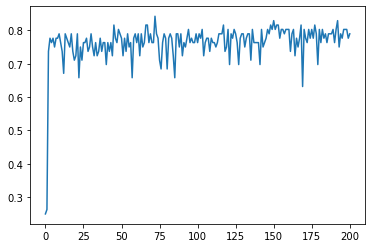

In [6]:
plt.plot(test_acc)

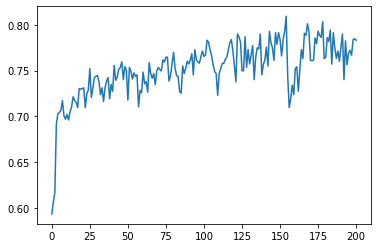

In [10]:
plt.plot(acc)

(array([0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

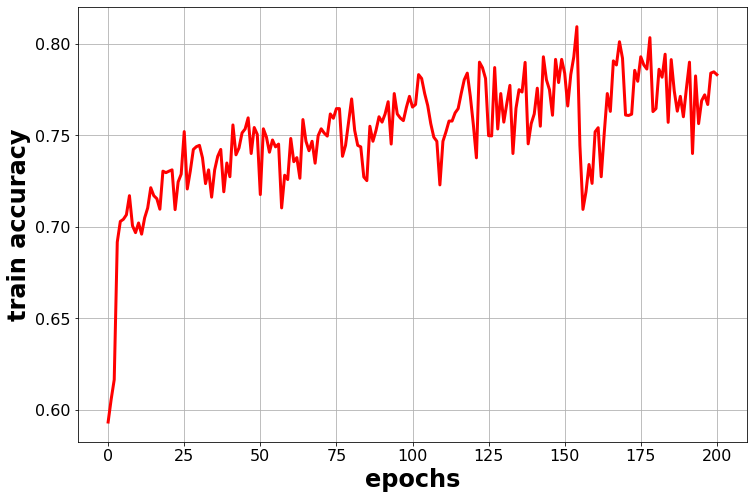

In [7]:
plt.figure(figsize=(12,8))
plt.plot(acc, linewidth=3, color='red')
plt.grid()
plt.xlabel('epochs', fontsize=(24), fontweight='bold')
plt.ylabel('train accuracy', fontsize=(24), fontweight='bold')
plt.xticks(fontsize=(16))
plt.yticks(fontsize=(16))

TypeError: text() missing 3 required positional arguments: 'x', 'y', and 's'

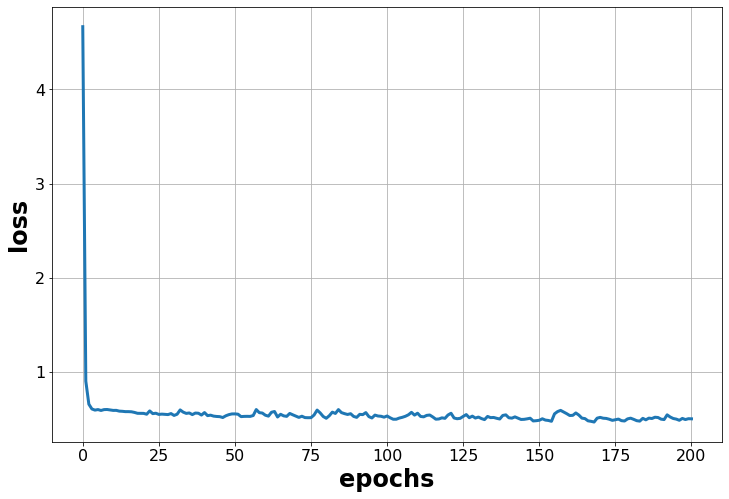

In [9]:
plt.figure(figsize=(12,8))
plt.plot(loss, linewidth=3)
plt.grid()
plt.xlabel('epochs', fontsize=(24), fontweight='bold')
plt.ylabel('loss', fontsize=(24), fontweight='bold')
plt.xticks(fontsize=(16))
plt.yticks(fontsize=(16))
plt.text(color='white')